In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
## Matplotlib settings
## inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 200,  # to adjust notebook inline plot size
    'savefig.dpi': 200,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.5, 2.625], # 4 x 3
#     'figure.figsize': [4*1.125, 3*1.125], # 4x3, full slide in keynote
    'font.family': 'serif',
    'figure.max_open_warning':100
}
mpl.rcParams.update(params)

## Get physical constants from Scipy
import scipy.constants as con
## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m
k = con.physical_constants['Boltzmann constant in eV/K'][0]

import scipy.integrate as int

import scipy.io as sio

import scipy.optimize as opt

import scipy.special as spl

In [3]:
misloc_pack_path = os.path.join(
    os.path.sep,
    'Users',
    'chair',
    'Documents',
    'Academia',
    'SuperRes',
    'Biteen_colab',
    'Mispolarization',
    'python',
#     'gitted',
    )

sys.path.append(misloc_pack_path)

import misloc_mispol_package as mmp
import misloc_mispol_package.calc.coupled_dipoles as cp
import misloc_mispol_package.optics.anal_foc_diff_fields as aff

In [4]:
import twosphere_temperature as tst
import pti_model as pti

In [5]:
a1 = 10
a2 = 15
eps_back = 1.473**2

# del_d = 4*a1

d = 3*a1
d_col_nm = np.array([[d, 0, 0]])*1e-7

hw = 2.2
sensorsize_nm = 1000

plot_hws = np.linspace(2.2, 2.7, 300)


# eps1 = -2.5676 + 1j*3.6391
n0 = eps_back
eps0 = n0**2

## pump power 600 micro watts = 600*1e-6 * 1e7 erg/s
# Eplane = (1.4444)**0.5 * 10**18 * 10**(-1)
Eplane = ((8*np.pi/c)*600*1e-6*1e7)**0.5

In [6]:
## Assign materialk porperties
au_eps_inf=9.82335326  # eps_inf
au_w_p=9.06705560/hbar  # w_p
au_gamma=0.0334860149/hbar  # gamma

In [7]:
def alpha_1_of_hw(hw):
    return cp.sparse_ret_sphere_polarizability_Drude(
        w=hw/hbar, 
#         eps_inf=14.2, 
#         w_p=10.0/hbar, 
#         gamma=0.20/hbar,
#         eps_b=1.33**2., 
        a=a1*1e-7, 
        eps_inf=au_eps_inf,  # eps_inf
        w_p=au_w_p,  # w_p
        gamma=au_gamma,  # gamma
        eps_b=eps_back,  # eps_b
#         a=41*1e-7
        )

def alpha_2_of_hw(hw):
    return cp.sparse_ret_sphere_polarizability_Drude(
        w=hw/hbar, 
        eps_inf=au_eps_inf,  # eps_inf
        w_p=au_w_p,  # w_p
        gamma=au_gamma,  # gamma
        eps_b=eps_back,  # eps_b
        a=a2*1e-7, 
        )

Text(0, 0.5, '$\\sigma$ [$\\mathrm{cm}^2$]')

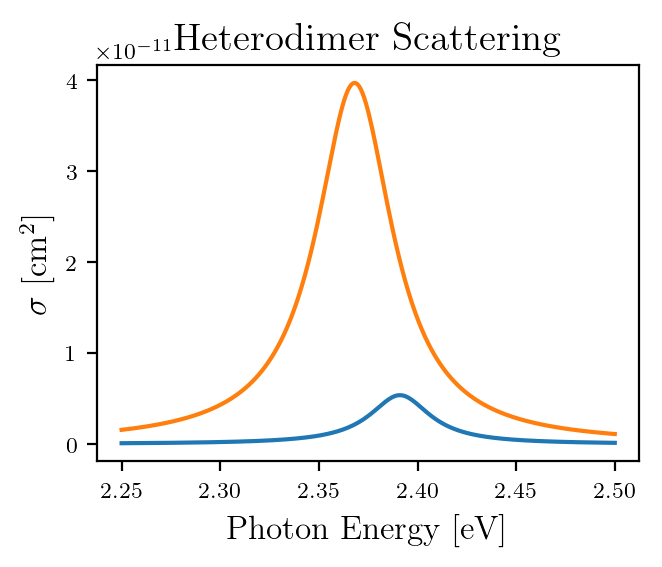

In [8]:
plot_hws = np.linspace(2.25, 2.5, 300)

sphere_1_scattering = (
    cp.sigma_prefactor(w=plot_hws/hbar, eps_b=eps_back)
    *
    np.abs(alpha_1_of_hw(plot_hws)[:, 0, 0])**2.
    )
sphere_2_scattering = (
    cp.sigma_prefactor(w=plot_hws/hbar, eps_b=eps_back)
    *
    np.abs(alpha_2_of_hw(plot_hws)[:, 0, 0])**2.
    )

plt.plot(plot_hws, sphere_1_scattering)
plt.plot(plot_hws, sphere_2_scattering)
plt.title("Heterodimer Scattering")
plt.xlabel('Photon Energy [eV]')
plt.ylabel(r'$\sigma$ [$\mathrm{cm}^2$]')


In [9]:
def coupled_dips_of_w(w):
    return  cp.coupled_dip_mags_both_driven(
        mol_angle=0,
        plas_angle=0,
        d_col = d_col_nm,
        E_d_angle=None,
        drive_hbar_w=w*hbar,
        alpha0_diag=alpha_1_of_hw(w*hbar),
        alpha1_diag=alpha_2_of_hw(w*hbar),
        n_b=eps_back**0.5,
        drive_amp=Eplane,)

coupled_scattering = cp.sigma_scat_coupled(
    dipoles_moments_per_omega=coupled_dips_of_w,
    d_col=d_col_nm,
    drive_hbar_w=plot_hws,
    n_b=eps_back**0.5,
    E_0=Eplane,)


In [10]:
coupled_scattering[0].shape

(300,)

Text(0, 0.5, '$\\sigma$ [$\\mathrm{cm}^2$]')

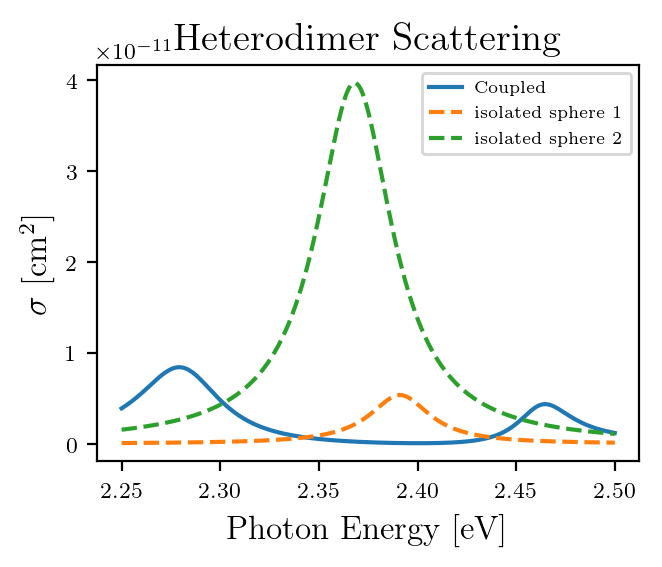

In [11]:
plt.plot(plot_hws, coupled_scattering[0], label='Coupled')
# plt.plot(plot_hws, coupled_scattering[1][2], label='sphere 1 component')
# plt.plot(plot_hws, coupled_scattering[1][2], label='sphere 1 component')

plt.plot(plot_hws, sphere_1_scattering, ls='--', label='isolated sphere 1')
plt.plot(plot_hws, sphere_2_scattering, ls='--', label='isolated sphere 2')
plt.legend(fontsize=6)
plt.title("Heterodimer Scattering")
plt.xlabel('Photon Energy [eV]')
plt.ylabel(r'$\sigma$ [$\mathrm{cm}^2$]')

In [12]:

coupled_absorption = cp.sigma_abs_coupled(
    mol_angle=0,
    plas_angle=0,
    d_col = d_col_nm,
    E_d_angle=None,
    drive_hbar_w=plot_hws,
    alpha0_diag=alpha_1_of_hw(plot_hws),
    alpha1_diag=alpha_2_of_hw(plot_hws),
    n_b=eps_back**0.5,
    drive_amp=Eplane,)

sphere_1_absorption = cp.single_dip_absorption(
    mol_angle=0,
    E_d_angle=0,
    alpha_0_p0=alpha_1_of_hw(plot_hws),
    drive_hbar_w=plot_hws,
    drive_amp=Eplane,
    n_b=eps_back**0.5,)

sphere_2_absorption = cp.single_dip_absorption(
    mol_angle=0,
    E_d_angle=0,
    alpha_0_p0=alpha_2_of_hw(plot_hws),
    drive_hbar_w=plot_hws,
    drive_amp=Eplane,
    n_b=eps_back**0.5,)

Text(0, 0.5, '$\\sigma$ [$\\mathrm{cm}^2$]')

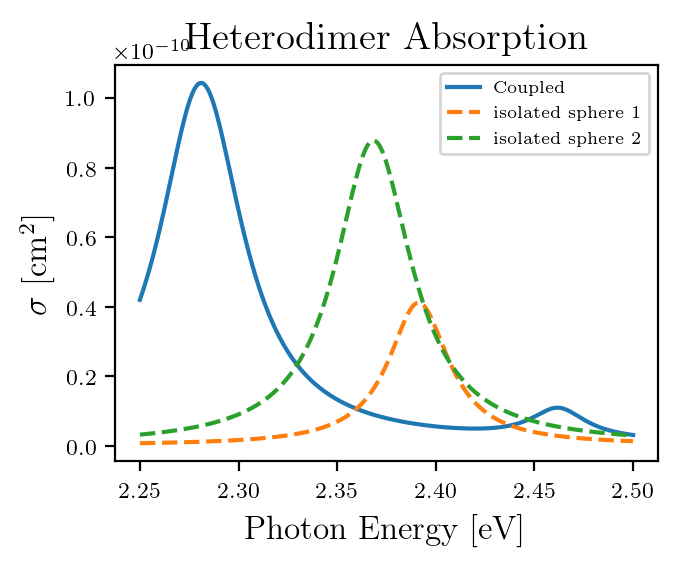

In [13]:
plt.plot(plot_hws, coupled_absorption[0], label='Coupled')
# plt.plot(plot_hws, coupled_scattering[1][2], label='sphere 1 component')
# plt.plot(plot_hws, coupled_scattering[1][2], label='sphere 1 component')

plt.plot(plot_hws, sphere_1_absorption, ls='--', label='isolated sphere 1')
plt.plot(plot_hws, sphere_2_absorption, ls='--', label='isolated sphere 2')
plt.legend(fontsize=6)
plt.title("Heterodimer Absorption")
plt.xlabel('Photon Energy [eV]')
plt.ylabel(r'$\sigma$ [$\mathrm{cm}^2$]')

Plot dipole components of power absorbed

Text(0, 0.5, '$\\sigma$ [$\\mathrm{cm}^2$]')

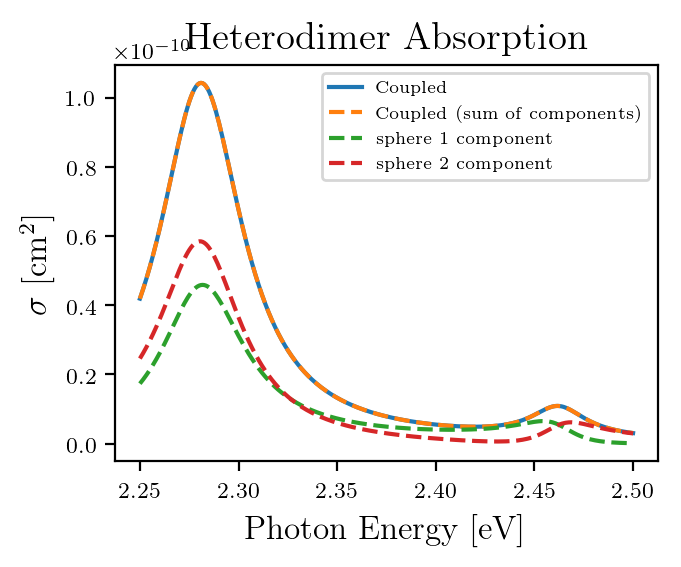

In [14]:
plt.plot(plot_hws, coupled_absorption[0], label='Coupled')
plt.plot(
    plot_hws, 
    coupled_absorption[1][0]-coupled_absorption[1][1]+coupled_absorption[1][2]-coupled_absorption[1][3], 
    ls='--',
    label='Coupled (sum of components)')
# plt.plot(plot_hws, coupled_scattering[1][2], label='sphere 1 component')
# plt.plot(plot_hws, coupled_scattering[1][2], label='sphere 1 component')

plt.plot(
    plot_hws, 
    coupled_absorption[1][0]-coupled_absorption[1][1], 
    ls='--', 
    label='sphere 1 component')
plt.plot(
    plot_hws, 
    coupled_absorption[1][2]-coupled_absorption[1][3], 
    ls='--', 
    label='sphere 2 component')
plt.legend(fontsize=6)
plt.title("Heterodimer Absorption")
plt.xlabel('Photon Energy [eV]')
plt.ylabel(r'$\sigma$ [$\mathrm{cm}^2$]')

which supports what I would have expected, that the larger sphere is dominating absorption at the low energy mode

Find peak energies

In [15]:
bond_enei = plot_hws[np.argmax(coupled_scattering[0])]
anti_enei = plot_hws[round(len(plot_hws)/2)+
    np.argmax(coupled_scattering[0][round(len(plot_hws)/2):])]

In [16]:
bond_enei

2.279264214046823

In [17]:
anti_enei

2.4648829431438126

# CAlculate coupled abs for pump excitation

In [18]:
eps_at_bond = cp.drude_model(
    w=bond_enei/hbar, 
    eps_inf=au_eps_inf,  # eps_inf
    w_p=au_w_p,  # w_p
    gamma=au_gamma,)
eps_at_anti = cp.drude_model(
    w=anti_enei/hbar, 
    eps_inf=au_eps_inf,  # eps_inf
    w_p=au_w_p,  # w_p
    gamma=au_gamma,)

In [20]:
def elec(dip_angle, x, y, k):
    """ Dipole field of an x oriented dipole"""
    
    E = aff.E_field(
        dipole_orientation_angle=dip_angle, 
        xi=x, 
        y=y, 
        k=k
        )
    
    return E#/k**3


def g(
    d_angle,
    d, w, 
    scale=1, 
    n_b=n0,
    p1_angle=0, p2_angle=0,):
    
    ## rotate d vector
    R = cp.rotation_by(d_angle)
    d_col = (R @ np.array([[d, 0, 0]]).T).T
    
    ## Get coupling strength from misloc package
    G = cp.G(
        drive_hbar_w=hbar*w, 
        d_col=d_col, 
        n_b=n_b)
    ## but this was implemented to process multiple seperations d or 
    ## frequencies w, so returns shape (1, 3, 3)
    if G.shape[0] is 1:
        G = G[0]
    
    def p_hat(angle):
        return cp.rotation_by(angle) @ np.array([1,0,0])[:,None]
    
    g = p_hat(p1_angle).T @ G @ p_hat(p2_angle)
    
    return g[...,0,:]


def p_coupled(
    w, d,
    alpha, other_alpha,
    probe_E=Eplane):

    p = (
        (alpha*(1 + g(0, d, w,)*other_alpha)*probe_E)
        /
        (1 - alpha*other_alpha*g(0, d, w,)**2)
        ) 
    
    if len(p.ravel()) is 1:
        p = p.ravel()
    
    return p

def pow_abs_coupled(
    w, d,
    alpha, that_alpha,
    x_dip=None,
    x_that_dip=None,
    x_obs=None,    
    probe_E=Eplane,
    n_b=n0,
    imaging_mode=None
    ): 
    """ Defines the power absorbed by one of two coupled dipoles.
    
        Assumes scalar polarizabilities
        """
    x_obs = np.asarray(x_obs)
    
    if x_dip is None and x_that_dip is None:
        x_dip = -d/2
        x_that_dip = d/2
    
    if imaging_mode is None:
        raise ValueError("'imaging_mode' must be 'wf' or 'cf'")
        
    k = w*n_b/c    
    _g = g(0, d, w,)
    if len(np.asarray([x_obs])) is 1:
        _g = _g.ravel()
    
    ## Set up incident field depensing on imaging modality
    if imaging_mode is 'cf':
        if x_obs is None:
            raise ValueError("Need 'x_obs' if 'imaging_mode'='cf'")
        ## Define spactially dependent driving field
        this_probe_E = elec(
            0, 
            x=x_dip-x_obs,
            y=0, 
            k=k
            )[0] * probe_E
        that_probe_E = elec(
            0, 
            x=x_that_dip-x_obs,
            y=0, 
            k=k
            )[0] * probe_E
    elif imaging_mode is 'wf':
        this_probe_E = probe_E
        that_probe_E = probe_E
        
    print(f"_g is shape: {_g.shape}")
    ## Work done on dipole by incident field and coupling
    E_tot_time_geom_coupling = (
        (this_probe_E + _g*that_alpha*that_probe_E)
        /
        (1 - alpha*that_alpha*_g**2)
        )
    
    p = alpha*E_tot_time_geom_coupling 
    print(f'nb p = {p}')
    
    alpha_inv_star_dot_p_star = np.conj(E_tot_time_geom_coupling) 
    
    term_1 = np.imag(p * alpha_inv_star_dot_p_star)
    
    ## Define work done on dipole by its own field (Larmore power)
    term_2 = (2/3) * k**3. * np.abs(p)**2. 
    
    _pow_abs = w/2 * (
        term_1 
        - term_2
        )
    
    return _pow_abs

## Test power absorbed calculation here matched module

In [21]:
alpha_1_of_hw(plot_hws).shape

(300, 3, 3)

In [22]:
g(0, d*1e-7, plot_hws[0]/hbar,)

array([9.17515663e+16+9.54988599e+15j])

In [24]:
alpha_1_of_hw(plot_hws[0])

array([[4.61394655e-18+5.28330402e-19j, 0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j],
       [0.00000000e+00+0.00000000e+00j, 4.61394655e-18+5.28330402e-19j,
        0.00000000e+00+0.00000000e+00j],
       [0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
        4.61394655e-18+5.28330402e-19j]])

In [25]:
coupled_absorption = cp.sigma_abs_coupled(
    mol_angle=0,
    plas_angle=0,
    d_col = d_col_nm,
    E_d_angle=None,
    drive_hbar_w=plot_hws,
    alpha0_diag=alpha_1_of_hw(plot_hws),
    alpha1_diag=alpha_2_of_hw(plot_hws),
    n_b=eps_back**0.5,
    drive_amp=Eplane,)

spec_pow_test_1 = pow_abs_coupled(
    x_obs=1,
    x_dip=-d*1e-7/2,
    x_that_dip=d*1e-7/2,
    w=plot_hws/hbar, 
    d=d*1e-7,
    alpha=alpha_1_of_hw(plot_hws)[...,0,0], 
    that_alpha=alpha_2_of_hw(plot_hws)[...,0,0],
    probe_E=Eplane,
    n_b=n0,
    imaging_mode='wf'
    )

spec_pow_test_2 = pow_abs_coupled(
    x_obs=1,
    x_dip=-d*1e-7/2,
    x_that_dip=d*1e-7/2,
    w=plot_hws/hbar, 
    d=d*1e-7,
    alpha=alpha_2_of_hw(plot_hws)[...,0,0], 
    that_alpha=alpha_1_of_hw(plot_hws)[...,0,0],
    probe_E=Eplane,
    n_b=n0,
    imaging_mode='wf'
    )


_g is shape: (300,)
nb p = [ 2.68231174e-20+4.93004547e-20j  2.61421589e-20+5.03121644e-20j
  2.54083411e-20+5.13174169e-20j  2.46205377e-20+5.23128719e-20j
  2.37778520e-20+5.32949745e-20j  2.28796495e-20+5.42599691e-20j
  2.19255898e-20+5.52039190e-20j  2.09156583e-20+5.61227300e-20j
  1.98501956e-20+5.70121799e-20j  1.87299248e-20+5.78679530e-20j
  1.75559751e-20+5.86856796e-20j  1.63299009e-20+5.94609802e-20j
  1.50536955e-20+6.01895143e-20j  1.37297987e-20+6.08670320e-20j
  1.23610970e-20+6.14894291e-20j  1.09509159e-20+6.20528026e-20j
  9.50300474e-21+6.25535075e-20j  8.02151250e-21+6.29882115e-20j
  6.51095514e-21+6.33539479e-20j  4.97617528e-21+6.36481639e-20j
  3.42229418e-21+6.38687635e-20j  1.85465715e-21+6.40141440e-20j
  2.78773582e-22+6.40832239e-20j -1.29974709e-21+6.40754625e-20j
 -2.87526194e-21+6.39908700e-20j -4.44216200e-21+6.38300068e-20j
 -5.99493883e-21+6.35939749e-20j -7.52824866e-21+6.32843974e-20j
 -9.03697252e-21+6.29033914e-20j -1.05162709e-20+6.24535310e-20

In [26]:
spec_pow_test_2.shape

(300,)

Text(0, 0.5, '$\\sigma$ [$\\mathrm{cm}^2$]')

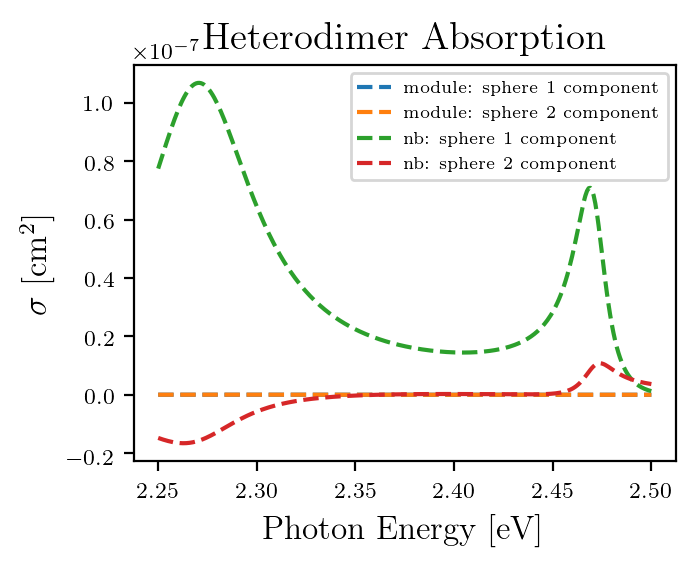

In [27]:
# plt.plot(plot_hws, coupled_absorption[0], label='Coupled')
# plt.plot(
#     plot_hws, 
#     coupled_absorption[1][0]-coupled_absorption[1][1]+coupled_absorption[1][2]-coupled_absorption[1][3], 
#     ls='--',
#     label='Coupled (sum of components)')
# # plt.plot(plot_hws, coupled_scattering[1][2], label='sphere 1 component')
# # plt.plot(plot_hws, coupled_scattering[1][2], label='sphere 1 component')

plt.plot(
    plot_hws, 
    coupled_absorption[1][0]-coupled_absorption[1][1], 
    ls='--', 
    label='module: sphere 1 component')
plt.plot(
    plot_hws, 
    coupled_absorption[1][2]-coupled_absorption[1][3], 
    ls='--', 
    label='module: sphere 2 component')
plt.plot(
    plot_hws, 
    spec_pow_test_1,
    ls='--', 
    label='nb: sphere 1 component')
plt.plot(
    plot_hws,     
    spec_pow_test_2,
    ls='--', 
    label='nb: sphere 2 component')
plt.legend(fontsize=6)
plt.title("Heterodimer Absorption")
plt.xlabel('Photon Energy [eV]')
plt.ylabel(r'$\sigma$ [$\mathrm{cm}^2$]')

## Back to calcs

In [28]:
bond_alpha_1 = alpha_1_of_hw(bond_enei)
bond_alpha_2 = alpha_2_of_hw(bond_enei)

_g is shape: (1,)
nb p = [ 3.25247274e-06-1.06994090e-05j  3.59730601e-06-1.12227538e-05j
  3.73191901e-06-1.10424059e-05j  3.62978251e-06-1.01092239e-05j
  3.27702734e-06-8.41727480e-06j  2.67433772e-06-6.00785532e-06j
  1.83813919e-06-2.97106906e-06j  8.00961766e-07+5.55314670e-07j
 -3.89103779e-07+4.38986202e-06j -1.66989435e-06+8.31433334e-06j
 -2.96759733e-06+1.20832434e-05j -4.20004644e-06+1.54358128e-05j
 -5.28077920e-06+1.81098547e-05j -6.12369717e-06+1.98570086e-05j
 -6.64812843e-06+2.04586285e-05j -6.78405843e-06+1.97415504e-05j
 -6.47727170e-06+1.75929258e-05j -5.69413548e-06+1.39733025e-05j
 -4.42575801e-06+8.92716945e-06j -2.69126879e-06+2.59026480e-06j
 -5.39996929e-07-4.80694079e-06j  1.94763586e-06-1.29400189e-05j
  4.66063886e-06-2.13958708e-05j  7.45946323e-06-2.96825802e-05j
  1.01795037e-05-3.72436707e-05j  1.26360242e-05-4.34763933e-05j
  1.46303706e-05-4.77534602e-05j  1.59572662e-05-4.94474552e-05j
  1.64129265e-05-4.79569898e-05j  1.58036793e-05-4.27335508e-05j


Text(0.5, 1.0, 'Bonding mode')

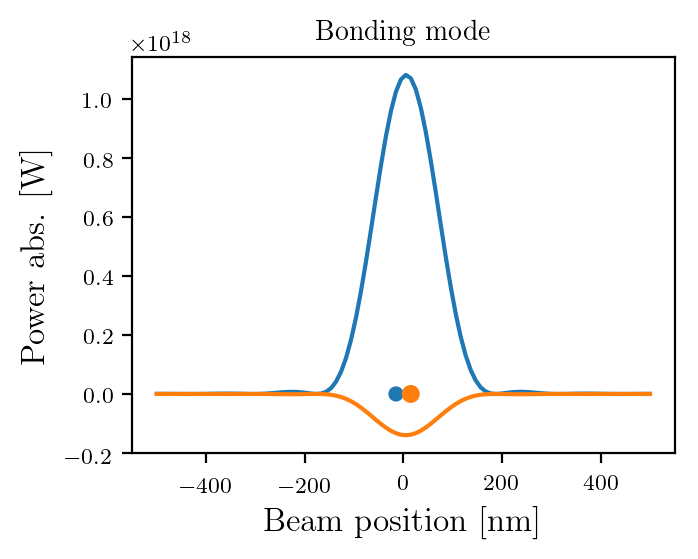

In [29]:
obs_points = np.linspace(-sensorsize_nm/2, sensorsize_nm/2, 100)*1e-7

bond_pow_test_1 = pow_abs_coupled(
    x_obs=obs_points,
    x_dip=-d*1e-7/2,
    x_that_dip=d*1e-7/2,
    w=bond_enei/hbar, 
    d=d*1e-7,
    alpha=bond_alpha_1[0,0], 
    that_alpha=bond_alpha_2[0,0],
    probe_E=Eplane,
    n_b=n0,
    imaging_mode='cf'
    )

bond_pow_test_2 = pow_abs_coupled(
    x_obs=obs_points,
    x_dip=+d*1e-7/2,
    x_that_dip=-d*1e-7/2,
    w=bond_enei/hbar, 
    d=d*1e-7,
    alpha=bond_alpha_2[0,0], 
    that_alpha=bond_alpha_1[0,0],
    probe_E=Eplane,
    n_b=n0,
    imaging_mode='cf'
    )

plt.plot(obs_points*1e7, bond_pow_test_1*1e-7)
plt.plot(obs_points*1e7, bond_pow_test_2*1e-7)

# plt.plot(obs_points*1e7, bond_pow_test_1+bond_pow_test_2)
# plt.plot(obs_points*1e7, bond_pow_test_2)
plt.xlabel('Beam position [nm]')
plt.ylabel('Power abs. [W]')
## plot positions
plt.scatter(
    np.asarray([-1, 1])*d/2,
    [0,0],
    c=['C0','C1'],
    s=[a1*2,a2*2])
plt.title('Bonding mode', fontsize=10)

Woh. Could this be correct? Is the total absorption negative?

In [30]:
np.any((bond_pow_test_1 + bond_pow_test_2)>0)

True

In [31]:
anti_alpha_1 = alpha_1_of_hw(anti_enei)
anti_alpha_2 = alpha_2_of_hw(anti_enei)

_g is shape: (1,)
nb p = [-3.42073775e-06-6.56431342e-06j -1.47733549e-06-4.40840757e-06j
  7.38216323e-07-1.73868891e-06j  3.08254186e-06+1.28882406e-06j
  5.39122229e-06+4.47947379e-06j  7.48882049e-06+7.61064102e-06j
  9.20042642e-06+1.04451399e-05j  1.03640524e-05+1.27466247e-05j
  1.08431080e-05+1.42961249e-05j  1.05381285e-05+1.49086979e-05j
  9.39692588e-06+1.44491138e-05j  7.42237762e-06+1.28454830e-05j
  4.67717016e-06+1.00997986e-05j  1.28496109e-06+6.29449379e-06j
 -2.57238301e-06+1.59431099e-06j -6.66159320e-06-3.75697319e-06j
 -1.07087253e-05-9.44513376e-06j -1.44134328e-05-1.50992428e-05j
 -1.74661708e-05-2.03101007e-05j -1.95674972e-05-2.46525652e-05j
 -2.04484590e-05-2.77107104e-05j -1.98909249e-05-2.91045143e-05j
 -1.77466548e-05-2.85166062e-05j -1.39539014e-05-2.57175184e-05j
 -8.55040740e-06-2.05878833e-05j -1.68180389e-06-1.31361066e-05j
  6.39537796e-06-3.51022542e-06j  1.53166106e-05+7.99707792e-06j
  2.46184136e-05+2.09510071e-05j  3.37534324e-05+3.47850398e-05j


Text(0.5, 1.0, 'Antibonding mode')

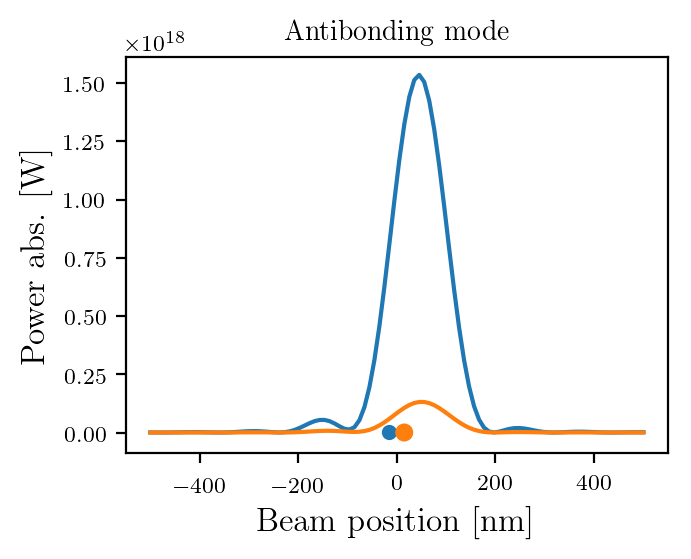

In [32]:
obs_points = np.linspace(-sensorsize_nm/2, sensorsize_nm/2, 100)*1e-7

anti_pow_test_1 = pow_abs_coupled(
    x_obs=obs_points,
    x_dip=-d*1e-7/2,
    x_that_dip=d*1e-7/2,
    w=anti_enei/hbar, 
    d=d*1e-7,
    alpha=anti_alpha_1[0,0], 
    that_alpha=anti_alpha_2[0,0],
    probe_E=Eplane,
    n_b=n0,
    imaging_mode='cf'
    )

anti_pow_test_2 = pow_abs_coupled(
    x_obs=obs_points,
    x_dip=+d*1e-7/2,
    x_that_dip=-d*1e-7/2,
    w=anti_enei/hbar, 
    d=d*1e-7,
    alpha=anti_alpha_2[0,0], 
    that_alpha=anti_alpha_1[0,0],
    probe_E=Eplane,
    n_b=n0,
    imaging_mode='cf'
    )

plt.plot(obs_points*1e7, anti_pow_test_1*1e-7)
plt.plot(obs_points*1e7, anti_pow_test_2*1e-7)
plt.xlabel('Beam position [nm]')

plt.ylabel('Power abs. [W]')
## plot positions
plt.scatter(
    np.asarray([-1, 1])*d/2,
    [0,0],
    c=['C0','C1'],
    s=[a1*2,a2*2])
plt.title('Antibonding mode', fontsize=10)



Text(0.5, 0, 'Beam position [nm]')

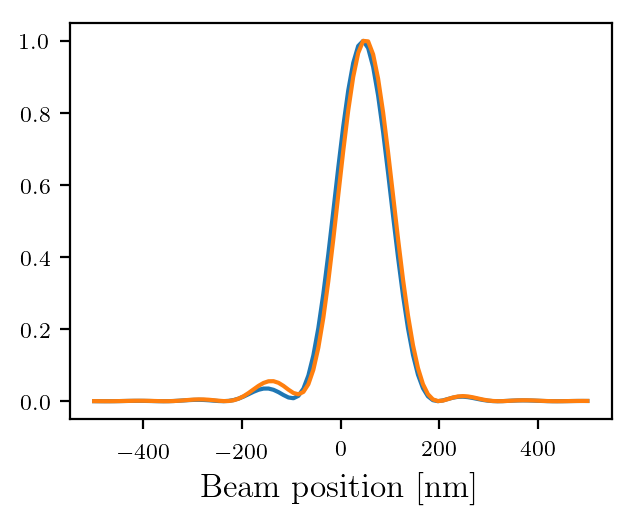

In [33]:
plt.plot(obs_points*1e7, anti_pow_test_1/anti_pow_test_1.max())
plt.plot(obs_points*1e7, anti_pow_test_2/anti_pow_test_2.max())
plt.xlabel('Beam position [nm]')

## Calculate temperatures
but first we need flux from power absorbed

In [34]:
sph_1_area = 4*np.pi*(a1*1e-9)**2.
sph_2_area = 4*np.pi*(a2*1e-9)**2.

bond_flux_1 = bond_pow_test_1 / sph_1_area
bond_flux_2 = bond_pow_test_2 / sph_2_area

anti_flux_1 = anti_pow_test_1 / sph_1_area
anti_flux_2 = anti_pow_test_2 / sph_2_area

Text(0.5, 0, 'Beam position [nm]')

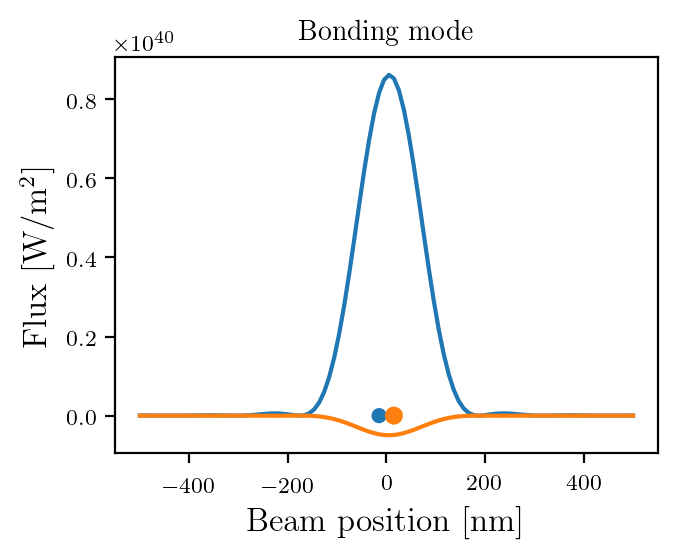

In [35]:
plt.plot(obs_points*1e7, bond_flux_1)
plt.plot(obs_points*1e7, bond_flux_2)
plt.ylabel(r'Flux [W/$\mathrm{m}^2$]')
## plot positions
plt.scatter(
    np.asarray([-1, 1])*d/2,
    [0,0],
    c=['C0','C1'],
    s=[a1*2,a2*2])
plt.title('Bonding mode', fontsize=10)
plt.xlabel('Beam position [nm]')

In [36]:
epsilon = 2*a1/d
l2_on_l1 = a2/a1

In [37]:
epsilon

0.6666666666666666

Text(0, 0.5, '$\\overline{\\theta}$')

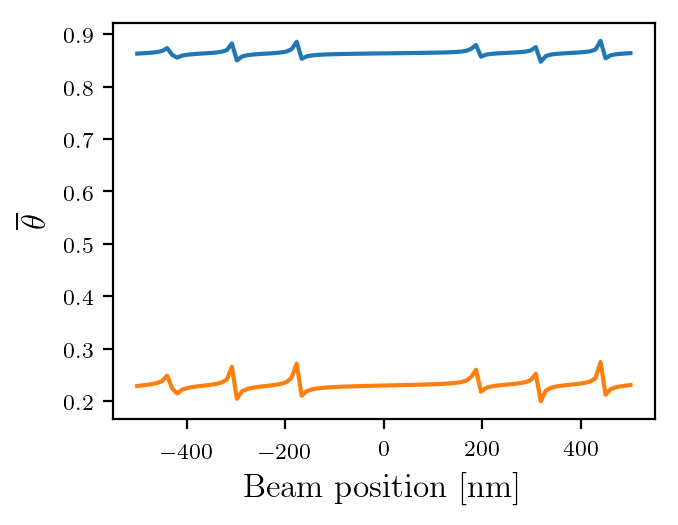

In [38]:
 ## Try this again 
bond_flux_ratios = bond_flux_2 / bond_flux_1

bond_temps = np.zeros_like(bond_flux_ratios)
bond_temps = bond_temps[None, :]*np.ones((2,1))

for i, q_ratio in enumerate(bond_flux_ratios):
    bond_temps[0, i] = tst.hetero_sph_unitless_temp(
        which_sphere=1,
        epsilon=epsilon, 
        max_m=4, 
        B_0=tst.converged_B_0(epsilon, 10, l2_on_l1=l2_on_l1, q2_on_q1=q_ratio),
        l2_on_l1=l2_on_l1, 
        q2_on_q1=q_ratio)
    bond_temps[1, i] = tst.hetero_sph_unitless_temp(
        which_sphere=2,
        epsilon=epsilon, 
        max_m=4, 
        B_0=tst.converged_B_0(epsilon, 10, l2_on_l1=l2_on_l1, q2_on_q1=q_ratio),
        l2_on_l1=l2_on_l1, 
        q2_on_q1=q_ratio)
    
plt.plot(obs_points*1e7, bond_temps[0, :])
plt.plot(obs_points*1e7, bond_temps[1, :])
plt.xlabel(r'Beam position [nm]')

plt.ylabel(r'$\overline{\theta}$')

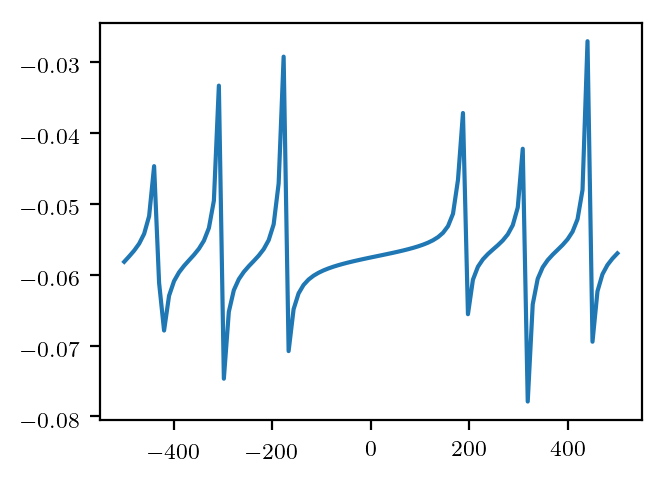

In [39]:
plt.plot(obs_points*1e7, bond_flux_ratios)

Convert Temperature to Kelvin

Text(0, 0.5, '$\\propto (T- T_r)$')

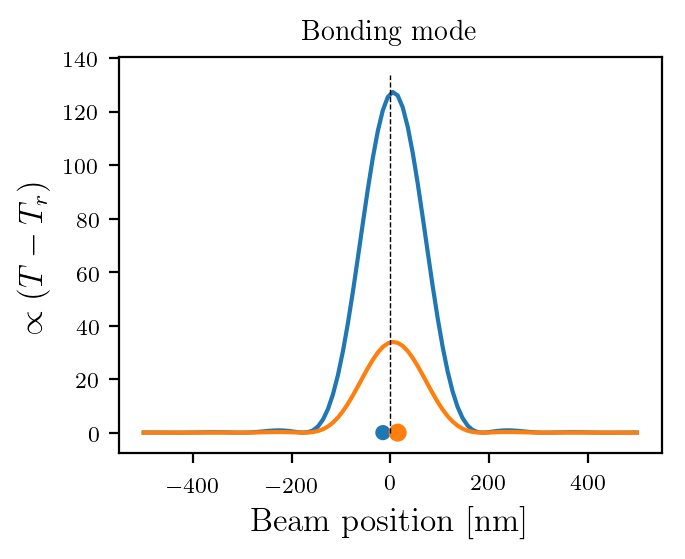

In [40]:
kappa_glycerol = 0.292 

def bond_temp_to_kelvin(theta):
    return theta*(bond_flux_1*a1*1e-9/kappa_glycerol)*5e-31
def anti_temp_to_kelvin(theta):
    return theta*(anti_flux_1*a1*1e-9/kappa_glycerol)*5e-31

plt.plot(obs_points*1e7, bond_temp_to_kelvin(bond_temps[0, :]))
plt.plot(obs_points*1e7, bond_temp_to_kelvin(bond_temps[1, :]))


plt.scatter(
    np.asarray([-1, 1])*d/2,
    [0,0],
    c=['C0','C1'],
    s=[a1*2,a2*2])
plt.plot([0,0], [0,plt.gca().get_ylim()[1]], lw=0.5, ls='--', c='black')
plt.title('Bonding mode', fontsize=10)
plt.xlabel('Beam position [nm]')
plt.ylabel(r'$\propto (T- T_r)$')

Text(0, 0.5, '$\\propto (T- T_r)$')

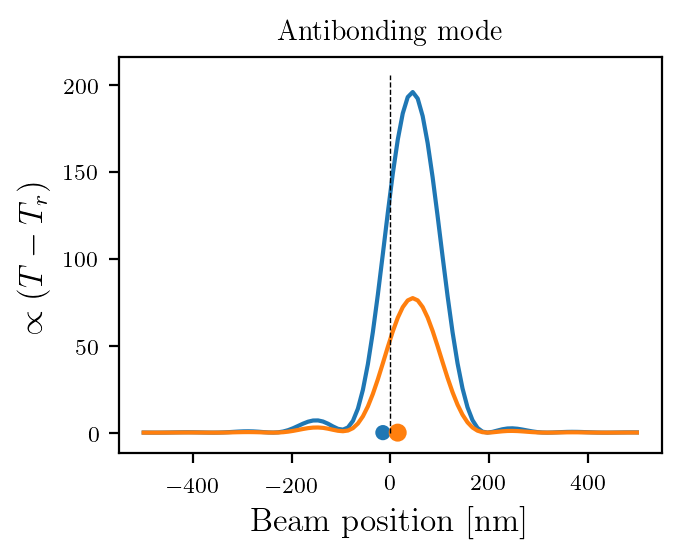

In [41]:
anti_temps = np.zeros_like(bond_flux_ratios)
anti_temps = anti_temps[None, :]*np.ones((2,1))

for i, q_ratio in enumerate(anti_flux_2/anti_flux_1):
    anti_temps[0, i] = tst.hetero_sph_unitless_temp(
        which_sphere=1,
        epsilon=epsilon, 
        max_m=4, 
        B_0=tst.converged_B_0(epsilon, 10, l2_on_l1=l2_on_l1, q2_on_q1=q_ratio),
        l2_on_l1=l2_on_l1, 
        q2_on_q1=q_ratio)
    anti_temps[1, i] = tst.hetero_sph_unitless_temp(
        which_sphere=2,
        epsilon=epsilon, 
        max_m=4, 
        B_0=tst.converged_B_0(epsilon, 10, l2_on_l1=l2_on_l1, q2_on_q1=q_ratio),
        l2_on_l1=l2_on_l1, 
        q2_on_q1=q_ratio)

plt.plot(obs_points*1e7, anti_temp_to_kelvin(anti_temps[0, :]))
plt.plot(obs_points*1e7, anti_temp_to_kelvin(anti_temps[1, :]))

plt.scatter(
    np.asarray([-1, 1])*d/2,
    [0,0],
    c=['C0','C1'],
    s=[a1*2,a2*2])
plt.plot([0,0], [0,plt.gca().get_ylim()[1]], lw=0.5, ls='--', c='black')

plt.title('Antibonding mode', fontsize=10)
plt.xlabel('Beam position [nm]')
plt.ylabel(r'$\propto (T- T_r)$')

# Build PTImages

In [42]:
probe_enei = 2.5

bonding_heated_particles = pti.temperature_dependent_particle(
    probe_enei, 
    eps_inf=au_eps_inf, 
    w_p=au_w_p,
    gamma=au_gamma)

bond_conf_image = bonding_heated_particles.conf_PTI(
    obs_points*1e7, 
    probe_enei/hbar, 
    T1=bond_temp_to_kelvin(bond_temps[0, :]), 
    b1=a1+5, 
    T2=bond_temp_to_kelvin(bond_temps[1, :]), 
    b2=a2+5, 
    d=d, 
    a1=a1, 
    a2=a2,)

# plt.plot(obs_points*1e7,bond_conf_image)

### Calculate widefield image 


bond_pow_wf_1 = pow_abs_coupled(
    x_obs=obs_points,
    x_dip=-d*1e-7/2,
    x_that_dip=d*1e-7/2,
    w=bond_enei/hbar, 
    d=d*1e-7,
    alpha=bond_alpha_1[0,0], 
    that_alpha=bond_alpha_2[0,0],
    probe_E=Eplane,
    n_b=n0,
    imaging_mode='wf'
    )

bond_pow_wf_2 = pow_abs_coupled(
    x_obs=obs_points,
    x_dip=+d*1e-7/2,
    x_that_dip=-d*1e-7/2,
    w=bond_enei/hbar, 
    d=d*1e-7,
    alpha=bond_alpha_2[0,0], 
    that_alpha=bond_alpha_1[0,0],
    probe_E=Eplane,
    n_b=n0,
    imaging_mode='wf'
    )

bond_pow_wf_1

bond_flux_wf_1 = bond_pow_wf_1 / sph_1_area
bond_flux_wf_2 = bond_pow_wf_2 / sph_2_area
q_ratio = (bond_flux_wf_2/bond_flux_wf_1)[0]
## Calculate sphere temperatures
bond_temps_wf = [0, 0]

bond_temps_wf[0] = tst.hetero_sph_unitless_temp(
    which_sphere=1,
    epsilon=epsilon, 
    max_m=4, 
    B_0=tst.converged_B_0(epsilon, 10, l2_on_l1=l2_on_l1, q2_on_q1=q_ratio),
    l2_on_l1=l2_on_l1, 
    q2_on_q1=q_ratio)
bond_temps_wf[1] = tst.hetero_sph_unitless_temp(
    which_sphere=2,
    epsilon=epsilon, 
    max_m=4, 
    B_0=tst.converged_B_0(epsilon, 10, l2_on_l1=l2_on_l1, q2_on_q1=q_ratio),
    l2_on_l1=l2_on_l1, 
    q2_on_q1=q_ratio)

## Execute probe measurement
bond_wifi_image = bonding_heated_particles.wfi_pti(
    l=obs_points*1e7, 
    w=probe_enei/hbar, 
    T1=bond_temp_to_kelvin(bond_temps_wf[0]), 
    b1=a1+5, 
    T2=bond_temp_to_kelvin(bond_temps_wf[1]), 
    b2=a2+5, 
    d=d, 
    a1=a1, 
    a2=a2,)

# plt.plot(
#     obs_points*1e7,
#     np.abs(bond_wifi_image)/np.abs(bond_wifi_image).max(),
#     label='widefield',
#     c='C4')
# plt.plot(
#     obs_points*1e7,
#     np.abs(bond_conf_image)/np.abs(bond_conf_image).max(),
#     label='confocal',
#     c='C3')

# plt.legend()
# plt.title("Bonding mode PTImages")
# plt.xlabel('[nm]')
# plt.ylabel('PT signal')

_g is shape: (1,)
nb p = [-1.85488432e-20+5.84983861e-20j]
_g is shape: (1,)
nb p = [-3.02040999e-20+1.19431769e-19j]


In [43]:
antibonding_heated_particles = pti.temperature_dependent_particle(
    probe_enei, 
    eps_inf=au_eps_inf, 
    w_p=au_w_p,
    gamma=au_gamma)

anti_conf_image = antibonding_heated_particles.conf_PTI(
    obs_points*1e7, 
    probe_enei/hbar, 
    T1=anti_temp_to_kelvin(anti_temps[0, :]), 
    b1=a1+5, 
    T2=anti_temp_to_kelvin(anti_temps[1, :]), 
    b2=a2+5, 
    d=d, 
    a1=a1, 
    a2=a2,)

# plt.plot(obs_points*1e7,anti_conf_image)

## Widefield for antibonding mode
anti_pow_wf_1 = pow_abs_coupled(
    x_obs=obs_points,
    x_dip=-d*1e-7/2,
    x_that_dip=d*1e-7/2,
    w=anti_enei/hbar, 
    d=d*1e-7,
    alpha=anti_alpha_1[0,0], 
    that_alpha=anti_alpha_2[0,0],
    probe_E=Eplane,
    n_b=n0,
    imaging_mode='wf'
    )

anti_pow_wf_2 = pow_abs_coupled(
    x_obs=obs_points,
    x_dip=+d*1e-7/2,
    x_that_dip=-d*1e-7/2,
    w=anti_enei/hbar, 
    d=d*1e-7,
    alpha=anti_alpha_2[0,0], 
    that_alpha=anti_alpha_1[0,0],
    probe_E=Eplane,
    n_b=n0,
    imaging_mode='wf'
    )

# anti_pow_wf_1

anti_flux_wf_1 = anti_pow_wf_1 / sph_1_area
anti_flux_wf_2 = anti_pow_wf_2 / sph_2_area
q_ratio = (anti_flux_wf_2/anti_flux_wf_1)[0]
## Calculate sphere temperatures
anti_temps_wf = [0, 0]

anti_temps_wf[0] = tst.hetero_sph_unitless_temp(
    which_sphere=1,
    epsilon=epsilon, 
    max_m=4, 
    B_0=tst.converged_B_0(epsilon, 10, l2_on_l1=l2_on_l1, q2_on_q1=q_ratio),
    l2_on_l1=l2_on_l1, 
    q2_on_q1=q_ratio)
anti_temps_wf[1] = tst.hetero_sph_unitless_temp(
    which_sphere=2,
    epsilon=epsilon, 
    max_m=4, 
    B_0=tst.converged_B_0(epsilon, 10, l2_on_l1=l2_on_l1, q2_on_q1=q_ratio),
    l2_on_l1=l2_on_l1, 
    q2_on_q1=q_ratio)

anti_wifi_image = antibonding_heated_particles.wfi_pti(
    l=obs_points*1e7, 
    w=probe_enei/hbar, 
    T1=anti_temp_to_kelvin(anti_temps_wf[0]), 
    b1=a1+5, 
    T2=anti_temp_to_kelvin(anti_temps_wf[1]), 
    b2=a2+5, 
    d=d, 
    a1=a1, 
    a2=a2,)

# plt.plot(
#     obs_points*1e7,
#     np.abs(anti_wifi_image)/np.abs(anti_wifi_image).max(),
#     label='widefield',
#     c='C4')
# plt.plot(
#     obs_points*1e7,
#     np.abs(anti_conf_image)/np.abs(anti_conf_image).max(),
#     label='confocal',
#     c='C3')

# plt.legend()
# plt.title("Antibonding mode PTImages")
# plt.xlabel('[nm]')
# plt.ylabel('Normalized PT signal')

_g is shape: (1,)
nb p = [-2.67606897e-20-2.48421273e-20j]
_g is shape: (1,)
nb p = [1.19763289e-20+4.63122856e-20j]


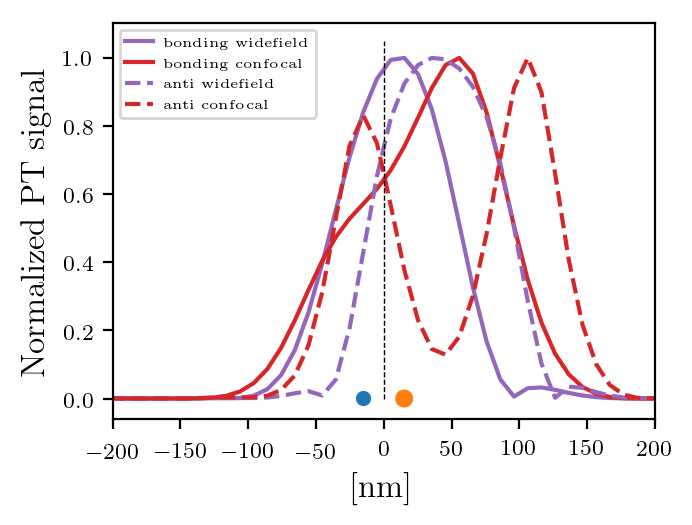

In [44]:
plt.plot(
    obs_points*1e7,
    np.abs(bond_wifi_image)/np.abs(bond_wifi_image).max(),
    label='bonding widefield',
    c='C4')
plt.plot(
    obs_points*1e7,
    np.abs(bond_conf_image)/np.abs(bond_conf_image).max(),
    label='bonding confocal',
    c='C3')

plt.plot(
    obs_points*1e7,
    np.abs(anti_wifi_image)/np.abs(anti_wifi_image).max(),
    label='anti widefield',
    ls = '--',
    c='C4'
    )
plt.plot(
    obs_points*1e7,
    np.abs(anti_conf_image)/np.abs(anti_conf_image).max(),
    label='anti confocal',
    ls = '--',
    c='C3'
    )

plt.plot([0,0], [0,plt.gca().get_ylim()[1]], lw=0.5, ls='--', c='black')
plt.xlim(-200, 200)
plt.legend(fontsize=5)
plt.xlabel('[nm]')
plt.ylabel('Normalized PT signal')
plt.scatter(
    np.asarray([-1, 1])*d/2,
    [0,0],
    c=['C0','C1'],
    s=[a1*2,a2*2])

In [45]:
np.all(anti_conf_image == bond_conf_image)

False

In [46]:
anti_conf_image-bond_conf_image

array([-1.63340704e-11,  2.17543938e-10,  4.89856018e-10,  4.80102814e-10,
       -1.62862310e-10, -1.55216823e-09, -3.35690010e-09, -4.85104649e-09,
       -5.27462791e-09, -4.33074338e-09, -2.47123228e-09, -6.83068392e-10,
        1.82265124e-10,  8.31934899e-11, -2.03261196e-10, -2.06902344e-11,
       -3.17896075e-10, -4.44434620e-09, -1.69513645e-08, -4.00798964e-08,
       -6.94686022e-08, -9.22621258e-08, -9.07582889e-08, -5.20956272e-08,
        1.98112262e-08,  9.92200088e-08,  1.44019037e-07,  1.18829172e-07,
        2.23071770e-08, -9.65306941e-08, -1.52151229e-07, -7.34544847e-08,
        1.25800684e-07,  3.04781880e-07,  2.46108078e-07, -1.54242329e-07,
       -5.75173266e-07,  7.96347761e-08,  3.87174091e-06,  1.36846787e-05,
        3.24944364e-05,  6.17284041e-05,  9.82760551e-05,  1.30752755e-04,
        1.37640900e-04,  9.38994318e-05, -5.96839373e-06, -1.14559887e-04,
       -1.43189802e-04, -5.08504691e-05,  1.20497959e-04,  3.10324031e-04,
        4.80233632e-04,  

In [47]:
# test_cf_image_comps = bonding_heated_particles.conf_PTI(
#     obs_points*1e7, 
#     bond_enei/hbar, 
#     T1=temp_to_kelvin(bond_temps[0, :]), 
#     b1=a1+5, 
#     T2=temp_to_kelvin(bond_temps[1, :]), 
#     b2=a2+5, 
#     d=d, 
#     a1=a1, 
#     a2=a2,
#     return_components=1)


# from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

# # with plt.style.context('classic'):
# cf_plots = []
# for comp in test_cf_image_comps:
#     ## Store hadle for legend
#     plot, = plt.plot(
#         obs_points*1e7, 
#         comp/bond_conf_image.max())
    
#     cf_plots.append(plot)
    

# # ## Plot wf components on top
# # plt.gca().set_prop_cycle(None)
# # wf_plots = []
# # for comp in test_image_comps:
# #     plot, = plt.plot(
# #         obs_points*1e7, 
# #         comp/wfi_pti(T1, T2, hw/hbar, obs_points*1e7, d, b1, b2, a1, a2,).max(),
# #         ls='--')
# #     wf_plots.append(plot)
    
# # l = plt.legend(
# #     [tuple(cf_plots), tuple(wf_plots)], 
# #     ['confocal components', 'widefield components'], 
# #     fontsize=6,
# #     numpoints=1,
# #    handler_map={tuple: HandlerTuple(ndivide=None)})
    

In [48]:
obs_points

array([-5.00000000e-05, -4.89898990e-05, -4.79797980e-05, -4.69696970e-05,
       -4.59595960e-05, -4.49494949e-05, -4.39393939e-05, -4.29292929e-05,
       -4.19191919e-05, -4.09090909e-05, -3.98989899e-05, -3.88888889e-05,
       -3.78787879e-05, -3.68686869e-05, -3.58585859e-05, -3.48484848e-05,
       -3.38383838e-05, -3.28282828e-05, -3.18181818e-05, -3.08080808e-05,
       -2.97979798e-05, -2.87878788e-05, -2.77777778e-05, -2.67676768e-05,
       -2.57575758e-05, -2.47474747e-05, -2.37373737e-05, -2.27272727e-05,
       -2.17171717e-05, -2.07070707e-05, -1.96969697e-05, -1.86868687e-05,
       -1.76767677e-05, -1.66666667e-05, -1.56565657e-05, -1.46464646e-05,
       -1.36363636e-05, -1.26262626e-05, -1.16161616e-05, -1.06060606e-05,
       -9.59595960e-06, -8.58585859e-06, -7.57575758e-06, -6.56565657e-06,
       -5.55555556e-06, -4.54545455e-06, -3.53535354e-06, -2.52525253e-06,
       -1.51515152e-06, -5.05050505e-07,  5.05050505e-07,  1.51515152e-06,
        2.52525253e-06,  